In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from collections import Counter
from imblearn.under_sampling import TomekLinks
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


Bad key "text.kerning_factor" on line 4 in
/Users/joseramirez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [3]:
# Reading in CSV

df = pd.read_csv('df.csv', index_col = 0)

In [4]:
# Dropping columns not used for modeling

X = df.drop(['LA1and10', 'CensusTract', 'State', 'County'], axis = 1)
y = df.LA1and10

In [5]:
# Making dataframe numeric

X = X.apply(pd.to_numeric)

In [6]:
#  Filling nulls with the median

X = X.fillna(X.median())

In [7]:
# Splitting the data with train_test_split

X_traintl, X_testtl, y_traintl, y_testtl = train_test_split(X, y, random_state=1)

In [8]:
# I am going to use TomekLinks to downsample because I have a significant class imbalance 
# in my food desert variable.

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_traintl, y_traintl)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 29538, 1: 20659})


In [9]:
# DummyClassifier

from sklearn.dummy import DummyClassifier

In [10]:
dummy_clf = DummyClassifier(random_state = 1, strategy = 'stratified')

In [11]:
dummy_clf.fit(X_res, y_res)

DummyClassifier(random_state=1, strategy='stratified')

In [12]:
y_predsdummy = dummy_clf.predict(X_testtl)

In [13]:
# F1

f1_score(y_testtl, y_predsdummy)

0.4035393297568452

In [14]:
# Recall Score

recall_score(y_testtl,y_predsdummy)

0.4217271006261832

## My priority for this project is having a great recall score. This is because I want to reduce False Negatives. In this case, a False Negative would be saying a Census Tract is not a food desert when it in fact is. As it pertains to my social case, I think it would be most detrimental for my model to have a false negative because it would mean the government would miss areas likely to become food deserts.

## In addition, I am using F1 as my secondary metric because a balance between false positives and false negatives is important. Although it's not my priority, I also do not want my model to cause the government to waste precious resources on areas that are not food deserts.

In [15]:
# Setting parameters for my GridSearch

param_dict={'max_depth': range(9,12,1),'criterion': ['entropy'], 'min_samples_leaf' : range(1,5,1), 'max_leaf_nodes': range(30,35,1), 'class_weight': ['balanced']}


In [16]:
# GridSearch

gs = GridSearchCV(DecisionTreeClassifier(random_state=1),
                  param_grid= param_dict,
                  scoring='f1', cv=3,verbose = 1, n_jobs=-1)

In [17]:
gs.fit(X_res, y_res)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.3s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': range(9, 12),
                         'max_leaf_nodes': range(30, 35),
                         'min_samples_leaf': range(1, 5)},
             scoring='f1', verbose=1)

In [18]:
gs.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, max_leaf_nodes=33, random_state=1)

In [19]:
gs.best_score_

0.70057442551974

In [20]:
y_predsgs=gs.best_estimator_.predict(X_testtl)

In [21]:
# F1 Score

f1_score(y_testtl,y_predsgs)

0.6764110929853182

In [22]:
# Recall Score

recall_score(y_testtl,y_predsgs)

0.7547691859618465

## Promising Recall and acceptable F1 Score for my first model

In [23]:
# Confusion Matrix

cm = confusion_matrix(y_testtl,y_predsgs)
classes = ['Not Food Desert', 'Food Desert']

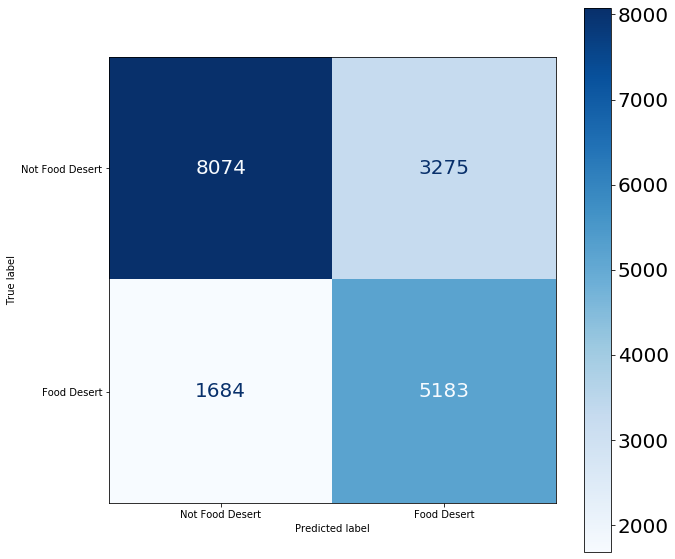

In [24]:
# Plot Confusion Matrix

fig, ax = plt.subplots(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

plot_confusion_matrix(gs, X_testtl, y_testtl, cmap=plt.cm.Blues, display_labels = classes, ax=ax)

In [25]:
# Random Forest

rf = RandomForestClassifier(class_weight = 'balanced',bootstrap = False, random_state=1)

param_dictrf={'n_estimators': [700], 'max_depth': range(19,21,1), 'criterion': ['entropy'],'max_leaf_nodes': range(205,206,1), 'min_samples_split': range(3,4,1), 'min_samples_leaf': [10], 'max_features': [10]}
gs_forest=GridSearchCV(rf,param_dictrf,scoring='f1',cv=3,verbose=1, n_jobs =-2)

# Fitting

gs_forest.fit(X_res,y_res)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 out of  12 | elapsed:  4.0min remaining:  8.0min
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  6.5min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              random_state=1),
             n_jobs=-2,
             param_grid={'criterion': ['entropy'], 'max_depth': range(19, 21),
                         'max_features': range(9, 11),
                         'max_leaf_nodes': range(205, 206),
                         'min_samples_leaf': [10],
                         'min_samples_split': range(3, 4),
                         'n_estimators': [700]},
             scoring='f1', verbose=1)

In [26]:
gs_forest.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=19, max_features=10,
                       max_leaf_nodes=205, min_samples_leaf=10,
                       min_samples_split=3, n_estimators=700, random_state=1)

In [27]:
gs_forest.best_score_

0.7318422664173475

In [28]:
y_predsgs_forest=gs_forest.best_estimator_.predict(X_testtl)

In [29]:
# F1 Score

f1_score(y_testtl,y_predsgs_forest)

0.7034207904350714

In [30]:
# Recall Score

recall_score(y_testtl, y_predsgs_forest)

0.7710790738313674

## Even better F1 Score and even better recall score. This model seems very promising

In [31]:
# Confusion Matrix

cm = confusion_matrix(y_testtl,y_predsgs_forest)
classes = ['Not Food Desert', 'Food Desert']

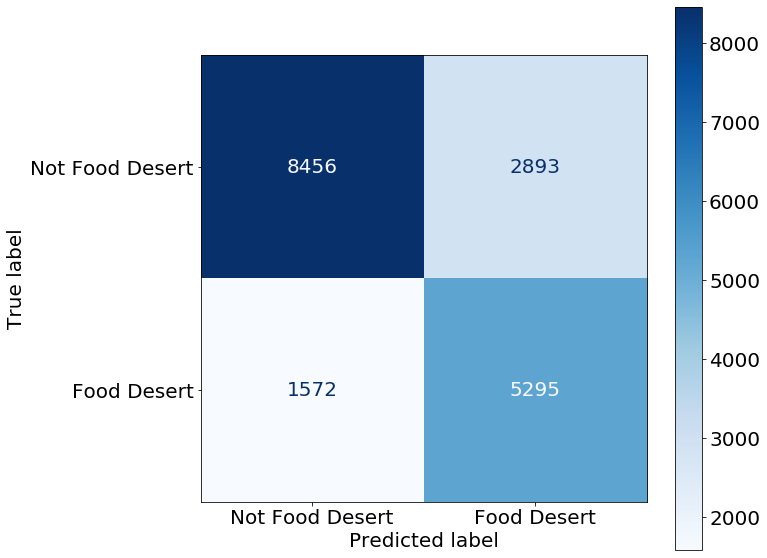

In [32]:
# Plot Confusion Matrix

fig, ax = plt.subplots(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

plot_confusion_matrix(gs_forest, X_testtl, y_testtl, cmap=plt.cm.Blues, display_labels = classes, ax=ax)

In [33]:
import xgboost as xgb

In [34]:
# XGBOOST Classifier

xgb_clf=xgb.XGBClassifier(class_weight = 'balanced',random_state=1)

# XGBOOST Parameter List

params={'n_estimators': [400],
        'min_child_weight': [12],
        'max_depth':[5],
        'gamma': [3],
        'subsample': [0.8],
        'colsample_bytree': [0.7],
        'max_delta_step':[1],
        'booster':['gbtree','gblinear']}

In [35]:
xgb_grid=GridSearchCV(xgb_clf,params,scoring ='f1', cv=3,verbose=1,n_jobs=-3)
# Fitting
xgb_grid.fit(X_res,y_res)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 out of   6 | elapsed:   43.6s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(class_weight='balanced', random_state=1),
             n_jobs=-3,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.7], 'gamma': [3],
                         'max_delta_step': [1], 'max_depth': [5],
                         'min_child_weight': [12], 'n_estimators': [400],
                         'subsample': [0.8]},
             scoring='f1', verbose=1)

In [36]:
xgb_grid.best_estimator_

XGBClassifier(class_weight='balanced', colsample_bytree=0.7, gamma=3,
              max_delta_step=1, max_depth=5, min_child_weight=12,
              n_estimators=400, random_state=1, subsample=0.8)

In [37]:
xgb_grid.best_score_

0.7375145475903403

In [38]:
y_predsxgb_grid=xgb_grid.best_estimator_.predict(X_testtl)

In [39]:
f1_score(y_testtl,y_predsxgb_grid)

0.7125429176711228

In [40]:
recall_score(y_testtl, y_predsxgb_grid)

0.710208242318334

## My most balanced model between F1 and recall, however the recall is a little low

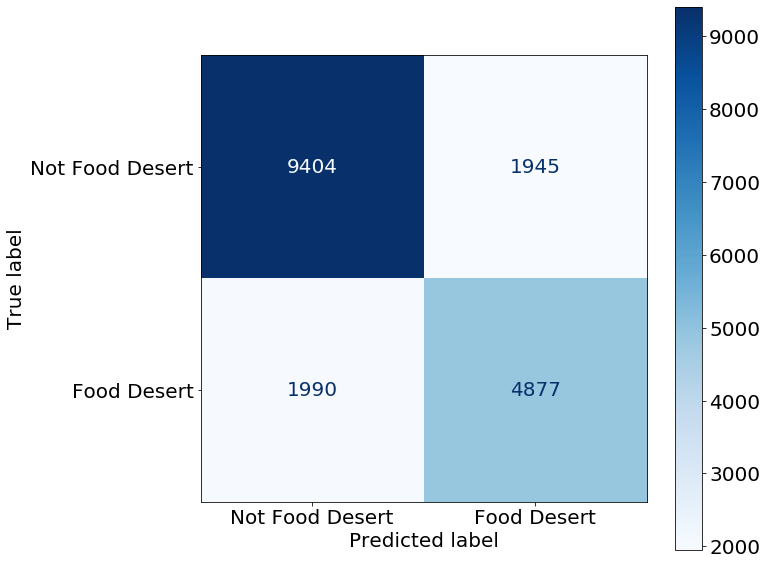

In [41]:
# Confusion Matrix

cm = confusion_matrix(y_testtl,y_predsxgb_grid)
classes = ['Not Food Desert', 'Food Desert']

# Plot Confusion Matrix

fig, ax = plt.subplots(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

plot_confusion_matrix(xgb_grid, X_testtl, y_testtl, cmap=plt.cm.Blues, display_labels = classes, ax=ax)


## Now let's use new sampling techniques I discovered to see if my model improves

In [42]:
from imblearn.combine import SMOTETomek, SMOTEENN


In [43]:
smtl = SMOTETomek()
X_ressmtl, y_ressmtl = smtl.fit_resample(X_traintl, y_traintl)
print('Resampled dataset shape %s' % Counter(y_ressmtl))

Resampled dataset shape Counter({0: 32090, 1: 32090})


## SMOTETomek uses Smote to oversample the minority class and then TomekLinks to undersample the majority class

In [44]:
paramssmtl={'min_child_weight': [11],
        'max_depth':[17],
        'gamma': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.9],
        'max_delta_step':[1],
        'booster':['gbtree','gblinear']}

In [45]:
xgb_gridsmtl=GridSearchCV(xgb_clf,paramssmtl,scoring ='f1', cv=3,verbose=1,n_jobs=-3)

# Fitting
xgb_gridsmtl.fit(X_ressmtl,y_ressmtl)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 out of   6 | elapsed:   58.7s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(class_weight='balanced', random_state=1),
             n_jobs=-3,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.9], 'gamma': [1],
                         'max_delta_step': [1], 'max_depth': [17],
                         'min_child_weight': [11], 'subsample': [0.8]},
             scoring='f1', verbose=1)

In [46]:
xgb_gridsmtl.best_estimator_

XGBClassifier(class_weight='balanced', colsample_bytree=0.9, gamma=1,
              max_delta_step=1, max_depth=17, min_child_weight=11,
              random_state=1, subsample=0.8)

In [47]:
xgb_gridsmtl.best_score_

0.7810021625732929

In [48]:
y_predsxgbsmtl_grid=xgb_gridsmtl.best_estimator_.predict(X_testtl)

In [49]:
# F1 Score

f1_score(y_testtl,y_predsxgbsmtl_grid)

0.7095163361392496

In [50]:
# Recall Score

recall_score(y_testtl, y_predsxgbsmtl_grid)

0.7241881462064949

## Balanced score, but not much of an improvement.

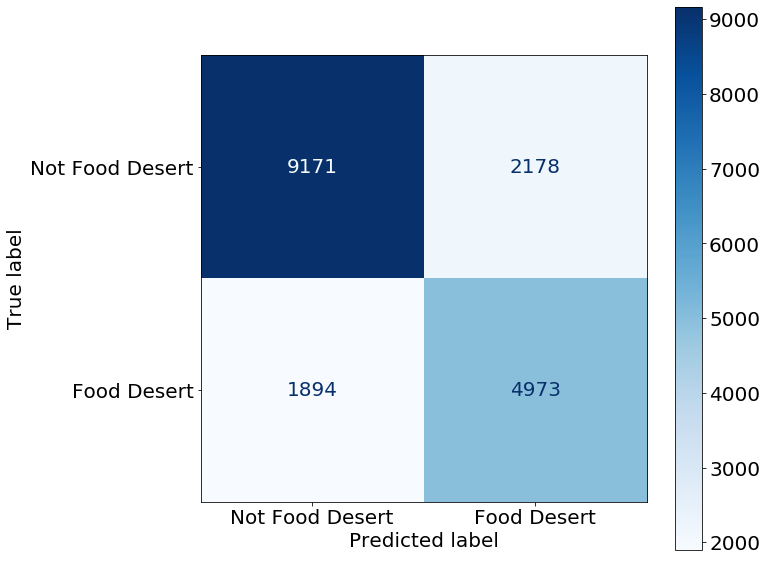

In [51]:
# Confusion Matrix

cm = confusion_matrix(y_testtl,y_predsxgbsmtl_grid)
classes = ['Not Food Desert', 'Food Desert']

# Plot Confusion Matrix


fig, ax = plt.subplots(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

plot_confusion_matrix(xgb_gridsmtl, X_testtl, y_testtl, cmap=plt.cm.Blues, display_labels = classes, ax=ax)


In [52]:
smen = SMOTEENN()
X_ressmen, y_ressmen = smen.fit_resample(X_traintl, y_traintl)
print('Resampled dataset shape %s' % Counter(y_ressmen))

Resampled dataset shape Counter({1: 16881, 0: 9859})


## SMOTEENN uses SMOTE to oversample the minority class and then uses a KNN of 3 to downsample the majority class

In [53]:
paramssmen={'min_child_weight': [9],
        'n_estimators': [500],
        'learning_rate':[.01],
        'max_depth':[16],
        'gamma': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'max_delta_step':[3],
        'booster':['gbtree','gblinear']}

In [54]:
xgb_gridsmen=GridSearchCV(xgb_clf,paramssmen,scoring ='f1', cv=3,verbose=1,n_jobs=-3)
##Fitting
xgb_gridsmen.fit(X_ressmen,y_ressmen)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 out of   6 | elapsed:  1.5min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(class_weight='balanced', random_state=1),
             n_jobs=-3,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.8], 'gamma': [1],
                         'learning_rate': [0.01], 'max_delta_step': [3],
                         'max_depth': [16], 'min_child_weight': [9],
                         'n_estimators': [500], 'subsample': [0.8]},
             scoring='f1', verbose=1)

In [55]:
xgb_gridsmen.best_estimator_

XGBClassifier(class_weight='balanced', colsample_bytree=0.8, gamma=1,
              learning_rate=0.01, max_delta_step=3, max_depth=16,
              min_child_weight=9, n_estimators=500, random_state=1,
              subsample=0.8)

In [56]:
xgb_gridsmen.best_score_

0.9006625255264665

In [57]:
y_predsxgbsmen_grid=xgb_gridsmen.best_estimator_.predict(X_testtl)

In [58]:
# F1 Score

f1_score(y_testtl,y_predsxgbsmen_grid)

0.6727918657356364

In [59]:
# Recall Score

recall_score(y_testtl,y_predsxgbsmen_grid)

0.799767001601864

## This model using XG Boost and the sampling technique SMOTEENN ended up being my best model with a recall of .80. Although it suffered a bit with its F1 score, it's gains with recall were enough for me to keep it as my strongest model.

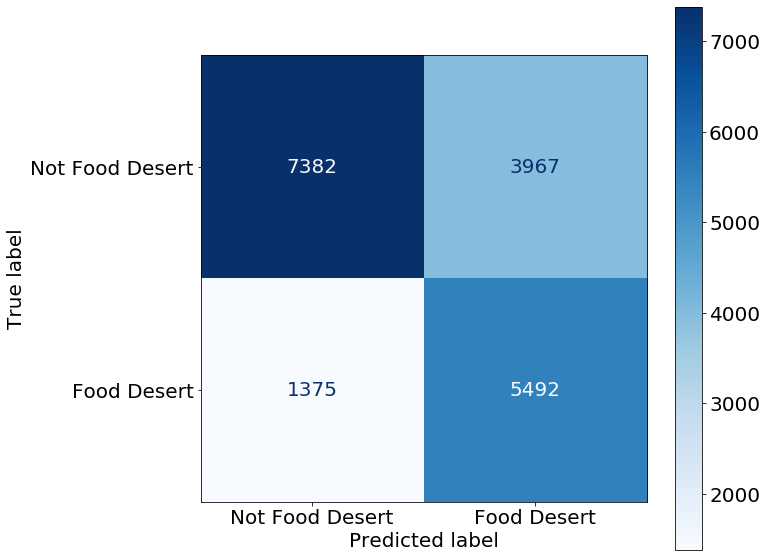

In [60]:
# Confusion Matrix

cm = confusion_matrix(y_testtl,y_predsxgbsmen_grid)
classes = ['Not Food Desert', 'Food Desert']
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Confusion Matrix

plt.rcParams.update({'font.size': 20})

plot_confusion_matrix(xgb_gridsmen, X_testtl, y_testtl, cmap=plt.cm.Blues, display_labels = classes, ax=ax)


In [63]:
fig.savefig('XGB_SMOTEENN_CM.png')

In [61]:
from xgboost import plot_importance

In [62]:
plt.rcParams["figure.figsize"] = (10, 7)

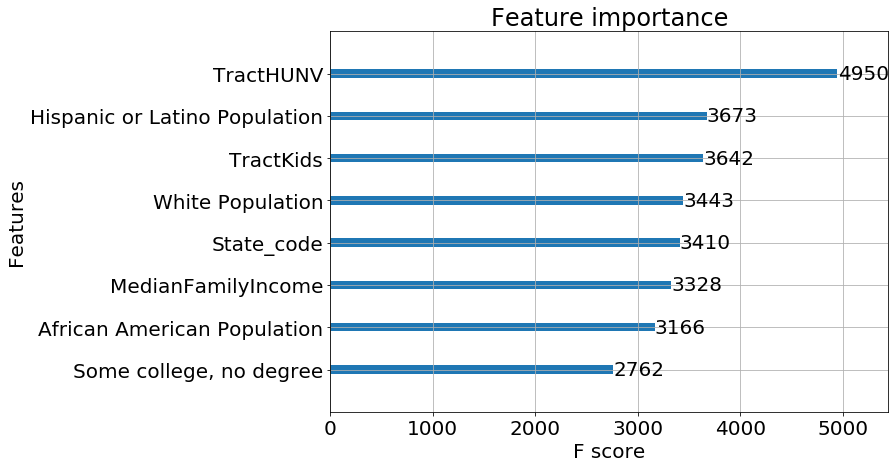

In [63]:
# Plotting the important features in my final model

ax = plot_importance(xgb_gridsmen.best_estimator_, max_num_features=8)

## From this graph we can see that the most important feature of the model was having vehicle access. We must improve vehicle access and public transportation in an effort to reduce the amount of food deserts in the United States

## In addition, the number of people in a census tract under the age of 18 was very important in our model. This suggest that companies may have a bias towards not building supermarkets in areas with a high amount of children as these may be seen as less profitable locations. 